(mmm_quickstart)=

# MMM Quickstart Guide

Welcome to **PyMC-Marketing**! This library provides powerful Bayesian modeling tools for marketing analytics.
PyMC-Marketing is built on top of [PyMC](https://www.pymc.io/), a probabilistic programming library that enables Bayesian inferenc. In this quickstart, we'll walk through fitting a basic Media Mix Model (MMM) in PyMC-Marketing.

## What is Media Mix Modeling?

Media Mix Modeling (MMM) helps marketers understand how different advertising channels contribute to business outcomes (like sales or conversions). MMM answers key questions:

- **Which channels drive the most sales?**
- **What is the Return on Ad Spend (ROAS) for each channel?**
- **How should I allocate my marketing budget?**

### Key Concepts

MMM accounts for two important phenomena in advertising:

1. **Adstock (Carry-over effect)**: The impact of advertising doesn't happen instantaneously—it builds up over time and gradually decays.
2. **Saturation**: Returns diminish as you increase spend—the first dollar spent is more effective than the millionth dollar.

Let's see how we can fit a basic MMM model to understand these effects and measure channel contributions.

```{note}
The focus of PyMC-Marketing is to provide tooling for real application. Typically, we need to think about the causal structure, lift test calibration and advanced budget optimization. This example should be seen as a first step to a more complex and rich tool-box to drive marketing decisions of the order of millions of dollars. In our example gallery, you will find extensive resources to help you and guide you through the MMM modeling iterative process.
```

```{tip}
- For an extended version of this example, see {ref}`mmm_example`. Here we delve deeper into the data generating process and model diagnostics. We also include ROAS estimation and out of sample predictions.
- If you want to see a complete end-to-end analysis, see {ref}`mmm_case_study`. Here we take a "real" world dataset and go through the entire process of model specification, fitting, optimization and scenario planning.
```

## Prepare Notebook

Let's import the necessary libraries:


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%config InlineBackend.figure_format = "retina"

%load_ext autoreload
%autoreload 2

In [2]:
# Set random seed for reproducibility
seed = sum(map(ord, "mmm"))
rng = np.random.default_rng(seed=seed)

## Load Data

We'll use a synthetic dataset that simulates weekly sales data along with spend on two marketing channels (`x1` and `x2`), plus some control variables for special events.


In [3]:
# Load the data
url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(url, parse_dates=["date_week"])

print(f"Data shape: {data.shape}")
data.head()

Data shape: (179, 8)


,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4


Let's visualize our target variable (sales) and the media spend over time:


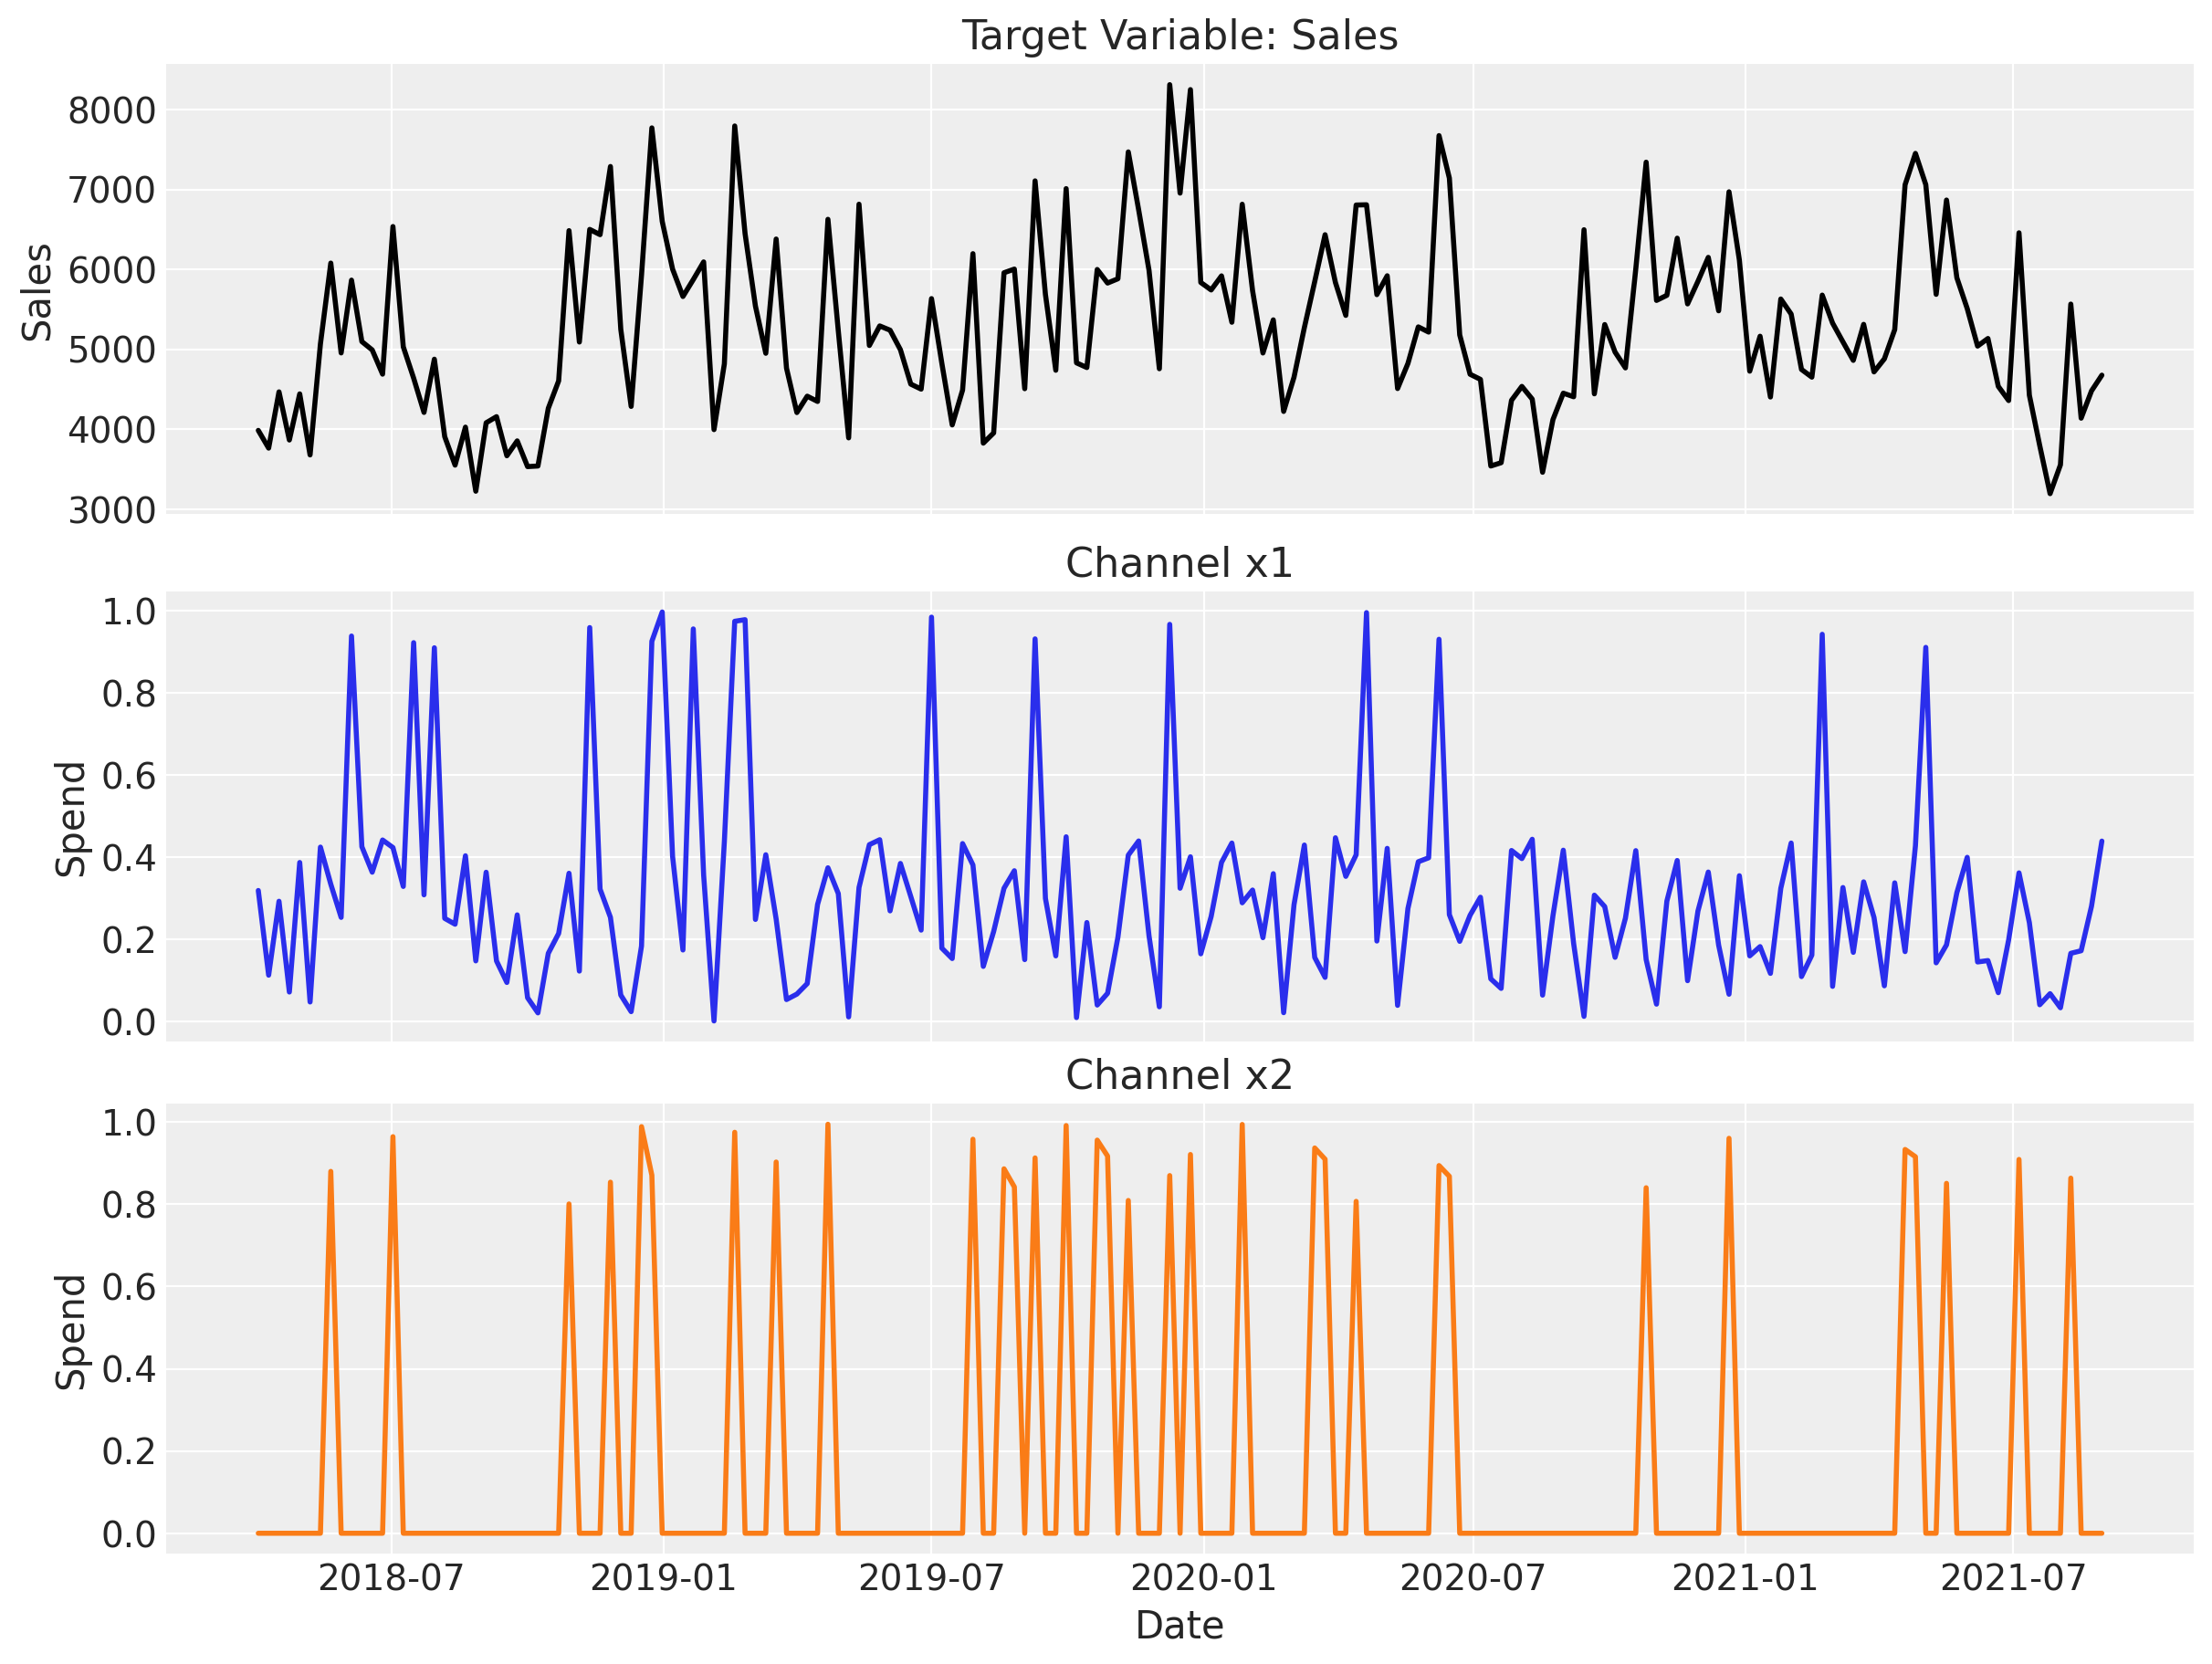

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Sales
axes[0].plot(data["date_week"], data["y"], color="black", linewidth=2)
axes[0].set(ylabel="Sales", title="Target Variable: Sales")

# Channel 1
axes[1].plot(data["date_week"], data["x1"], color="C0", linewidth=2)
axes[1].set(ylabel="Spend", title="Channel x1")

# Channel 2
axes[2].plot(data["date_week"], data["x2"], color="C1", linewidth=2)
axes[2].set(xlabel="Date", ylabel="Spend", title="Channel x2");

## Feature Engineering

For our MMM model, we'll include:

- **Trend**: A linear trend to capture long-term growth
- **Seasonality**: Yearly seasonality (handled automatically by the model)
- **Events**: Binary indicators for special events
- **Media channels**: Our two advertising channels


In [5]:
# Add a simple linear trend feature
data["t"] = range(len(data))

# Split into features (X) and target (y)
X = data.drop("y", axis=1)
y = data["y"]

print(f"Features: {X.columns.tolist()}")

Features: ['date_week', 'x1', 'x2', 'event_1', 'event_2', 'dayofyear', 't']


## Model Specification

Now we'll configure our MMM model. The key components are:

- **Adstock transformation**: We use `GeometricAdstock` with a maximum lag of 8 weeks
- **Saturation transformation**: We use `LogisticSaturation` to capture diminishing returns
- **Priors**: We can customize priors based on domain knowledge

### Setting Priors

One powerful feature of Bayesian modeling is the ability to incorporate prior knowledge. Here's a simple heuristic for channel priors based on spend share:


In [6]:
# Calculate spend share for each channel
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()

print("Spend share per channel:")
print(spend_share)

# Use spend share to inform prior on channel contributions
n_channels = 2
prior_sigma = n_channels * spend_share.to_numpy()

print(f"\nPrior sigma for channels: {prior_sigma}")

Spend share per channel:
x1    0.65632
x2    0.34368
dtype: float64

Prior sigma for channels: [1.31263903 0.68736097]


Now let's define our model configuration:


In [7]:
my_model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "saturation_beta": Prior("HalfNormal", sigma=prior_sigma),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

# Sampler configuration
my_sampler_config = {"progressbar": True}

# Initialize the MMM model
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2", "t"],
    yearly_seasonality=2,
    target_column="y",
)

In [8]:
mmm.build_model(X, y)

In [9]:
mmm.table()

                                  Variable  Expression                                 Dimensions                  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                           channel_scale =  Data                                       channel[2]                  
                            target_scale =  Data                                                                   
                            channel_data =  Data                                       date[179] × channel[2]      
                             target_data =  Data                                       date[179]                   
                            control_data =  Data                                       date[179] × control[3]      
                               dayofyear =  Data                                       date[179]                   
                                                                                                                   
                  intercept_contribution ~  Normal(0.5, 0.2)                                                       
                           adstock_alpha ~  Beta(1, 3)                                 channel[2]                  
                          saturation_lam ~  Gamma(3, f())                              channel[2]                  
                         saturation_beta ~  HalfNormal(0, <constant>)                  channel[2]                  
                           gamma_control ~  Normal(0, 0.05)                            control[3]                  
                           gamma_fourier ~  Laplace(0, 0.2)                            fourier_mode[4]             
                                 y_sigma ~  HalfNormal(0, 6)                                                       
                                                                                       Parameter count = 15        
                                                                                                                   
                    channel_contribution =  f(saturation_beta, saturation_lam,         date[179] × channel[2]      
                                            adstock_alpha)                                                         
 total_media_contribution_original_scale =  f(saturation_beta, saturation_lam,                                     
                                            adstock_alpha)                                                         
                    control_contribution =  f(gamma_control)                           date[179] × control[3]      
                    fourier_contribution =  f(gamma_fourier)                           date[179] × fourier_mode[4] 
         yearly_seasonality_contribution =  f(gamma_fourier)                           date[179]                   
                                                                                                                   
                                       y ~  Normal(f(intercept_contribution,           date[179]                   
                                            gamma_fourier, gamma_control,                                          
                                            saturation_beta, saturation_lam,                                       
                                            adstock_alpha), y_sigma)

### Prior Predictive Check

```{tip}
The prior predictive check is a good way to check that our priors are reasonable. Hence, is strongly recommended to perform this check before fitting the model. If you are new to Bayesian modeling, take a look into our {ref}`prior_predictive` guide notebook.
```

Before fitting, let's check that our priors are reasonable:


In [10]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=1_000, random_seed=rng)

# Plot prior predictive distribution
# fig, ax = plt.subplots(figsize=(12, 6))
# mmm.plot_prior_predictive(ax=ax, original_scale=True)
# ax.legend(loc="upper left")
# ax.set_title("Prior Predictive Check");

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, y, y_sigma]


<xarray.Dataset> Size: 1MB
Dimensions:  (date: 179, sample: 1000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 8kB MultiIndex
  * chain    (sample) int64 8kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 1MB -0.8195 0.5818 13.85 ... -22.36 2.111
Attributes:
    created_at:                 2026-01-27T16:07:01.166348+00:00
    arviz_version:              0.23.1
    inference_library:          pymc
    inference_library_version:  5.27.0+22.g51fe965fe
    pymc_marketing_version:     0.17.1

Overall, the prior predictive check looks good.

## Model Fitting

Now let's fit the model to our data using MCMC sampling. Observe that we can use different samplers by passing the `nuts_sampler` argument. For instance, we can use `numpyro` `nutpie` or `blackjax` samplers (see {ref}`other_nuts_samplers` for more details).


In [11]:
# Fit the model
_ = mmm.fit(
    X=X,
    y=y,
    chains=4,
    target_accept=0.85,
    nuts_sampler="pymc",
    random_seed=rng,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Output()

## Model Diagnostics

After fitting, we should check the model quality. Let's start with divergences:


In [12]:
# Check for divergences
n_divergences = mmm.idata["sample_stats"]["diverging"].sum().item()
print(f"Number of divergences: {n_divergences}")

if n_divergences == 0:
    print("✓ No divergences - sampling was successful!")
else:
    print("⚠ Warning: Model had divergences. Consider increasing target_accept.")

Number of divergences: 0
✓ No divergences - sampling was successful!


### Parameter Summary

Let's examine the estimated parameters:


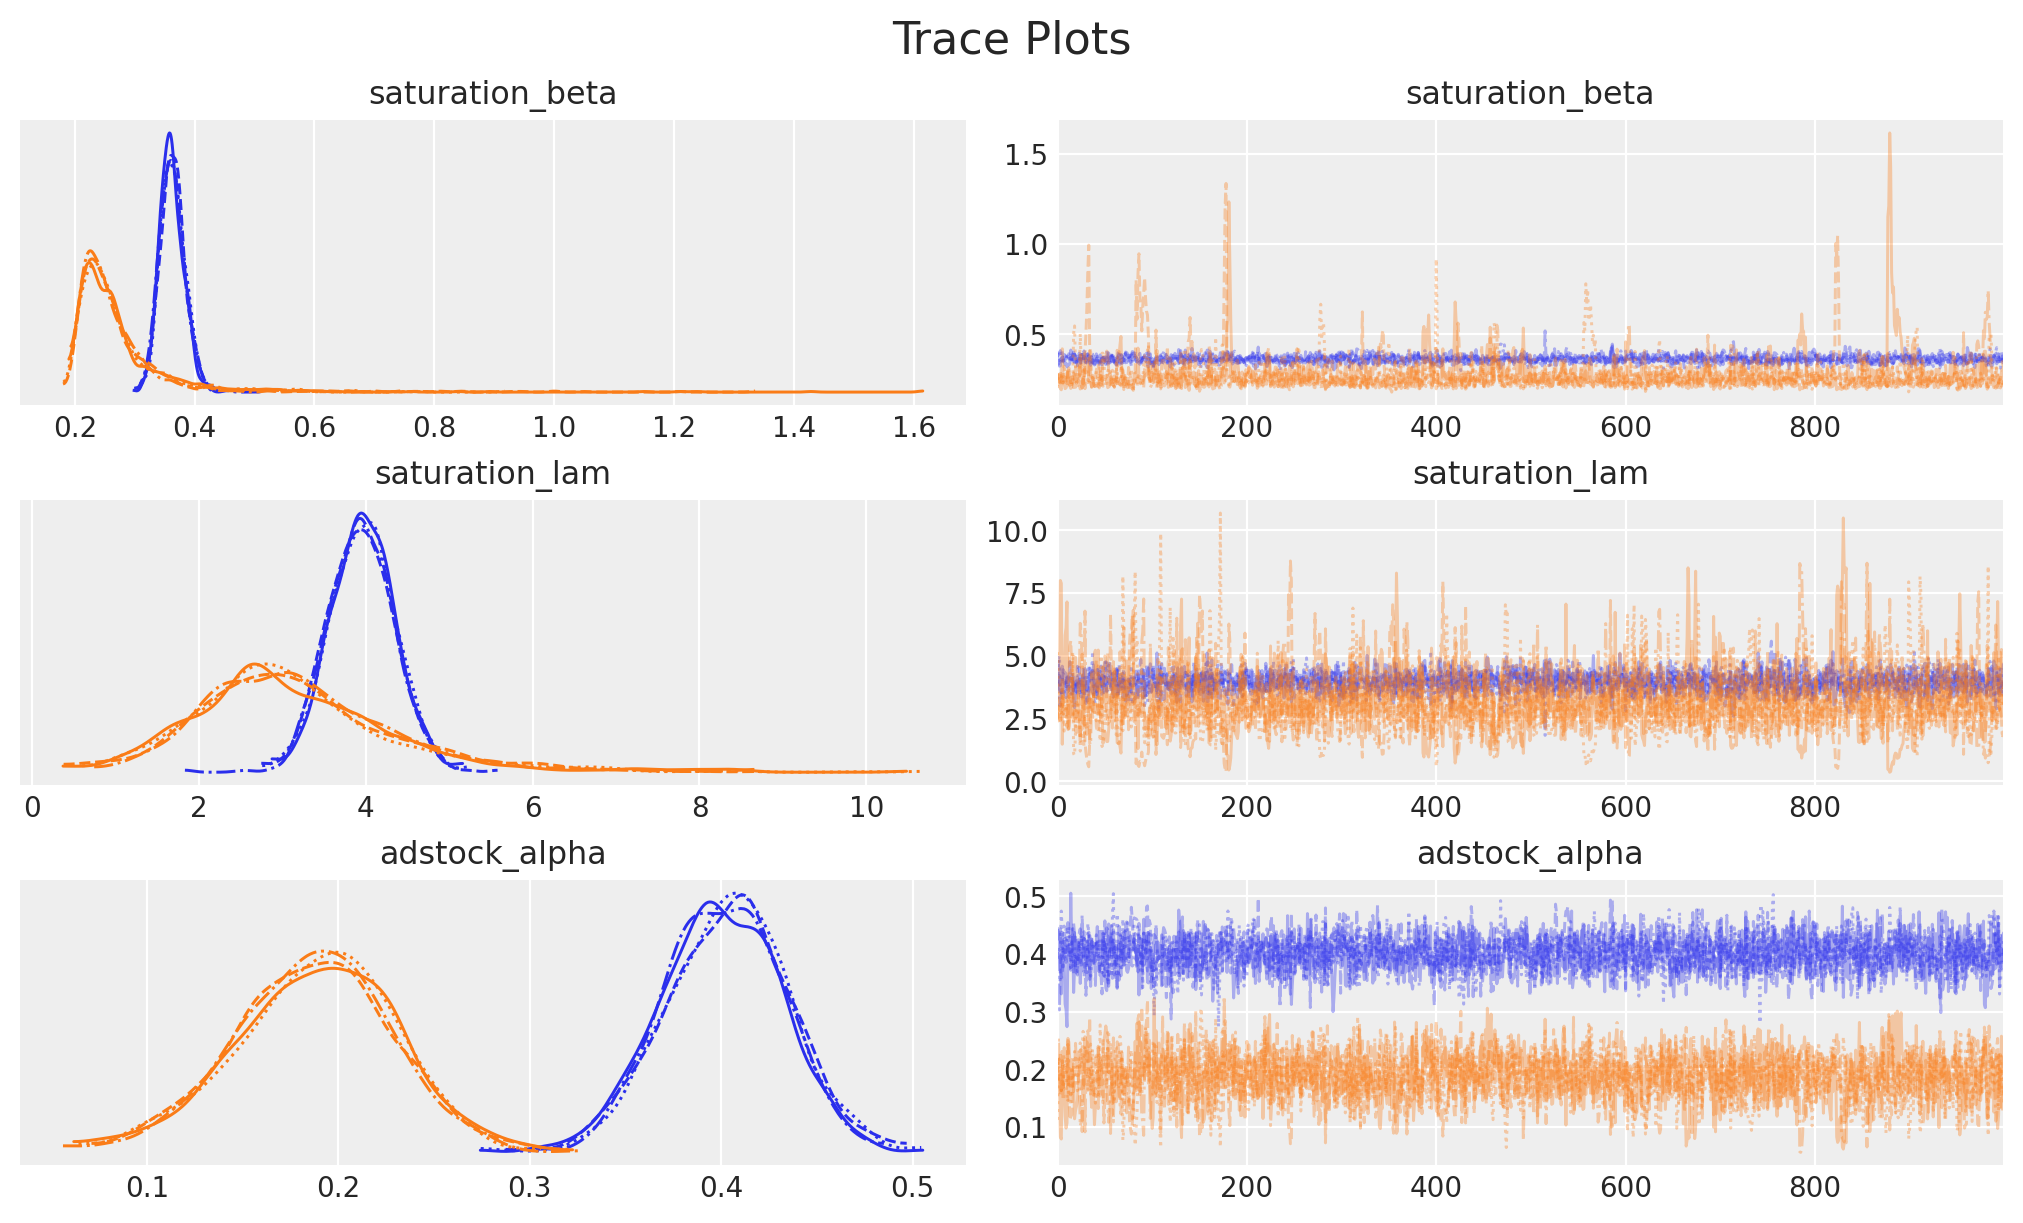

In [13]:
# Plot traces for key parameters
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
    ],
    compact=True,
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Trace Plots", fontsize=16);

Good trace plots should show:
- **Left side**: Smooth, bell-shaped distributions
- **Right side**: "Fuzzy caterpillar" patterns (good mixing) with no trends


### Posterior Predictive Check

How well does our model fit the observed data?


In [14]:
# Sample from posterior predictive distribution
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

# Plot model fit
# fig = mmm.plot_posterior_predictive(original_scale=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (date: 179, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 0.5031 0.4749 0.4758 ... 0.6007 0.634
Attributes:
    created_at:                 2026-01-27T16:07:21.716596+00:00
    arviz_version:              0.23.1
    inference_library:          pymc
    inference_library_version:  5.27.0+22.g51fe965fe

The model captures the observed data well if the black dots (actual sales) fall within the shaded uncertainty bands.


## Contribution Analysis

Now for the fun part—understanding how much each component contributes to sales!

### Component Contributions Over Time

Let's visualize the contribution of each component of the model over time:

In [15]:
# fig = mmm.plot_components_contributions(original_scale=True)
# plt.suptitle("Component Contributions to Sales", fontsize=16, y=1.02);

We see that we have captured the linear trend, events contributions and the seasonalities in the data. The remaining variation is due to the media channels, which is exactly what we want to understand.

### Waterfall Chart: Total Contribution by Component

A waterfall chart shows the total contribution of each component across the entire time period:


In [16]:
# Waterfall decomposition
# fig = mmm.plot_waterfall_components_decomposition();

This chart answers the question: **"How much did each component contribute to total sales?"**


### Channel Contribution Share

What percentage of media-driven sales comes from each channel?


In [17]:
# # Plot channel contribution share
# fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5));

### Direct Contribution Curves

These curves show the relationship between spend and contribution, accounting for saturation:


In [18]:
# # Plot direct contribution curves (saturation curves)
# fig = mmm.plot_direct_contribution_curves()
# plt.suptitle("Direct Contribution Curves", fontsize=16, y=1.02);

Notice how the curves flatten at higher spend levels—this is the saturation effect in action!


### Channel Contribution Grid

A complementary view of the media performance is to evaluate the channel contribution at **different share spend levels for the complete training period**. Concretely, if we denote by $\delta$ the input channel data percentage level, so that for $\delta = 1$ we have the model input spend data and for $\delta = 1.5$ we have a $50\%$ increase in the spend, then we can compute the channel contribution at a grid of $\delta$-values and plot the results:

In [19]:
# mmm.plot_channel_contribution_grid(start=0, stop=1.5, num=12, absolute_xrange=True);

Here we can also see the saturation effect and the relative contribution of each channel as a function of the share spend level on the aggregate time period.

## Next Steps

Congratulations! You've successfully fitted your first MMM model with PyMC-Marketing. 🎉

To continue your journey, check out:

- {ref}`mmm_example`: A comprehensive walkthrough including data generation, ROAS calculation, and more advanced diagnostics
- {ref}`mmm_budget_allocation_example`: Learn how to optimize your marketing budget allocation
- {ref}`mmm_lift_test`: Incorporate experimental results to improve model accuracy
- {ref}`mmm_tv_intercept`: Model changing baseline effects over time
- {ref}`mmm_time_varying_media_example`: Model changing media efficiency over time


## PyMC-Marketing MMM Features

PyMC-Marketing provides a comprehensive suite of tools for Marketing Mix Modeling:

| Feature | Description |
|---------|-------------|
| **Custom Priors and Likelihoods** | Tailor your model to your specific business needs by including domain knowledge via prior distributions |
| **Adstock Transformation** | Optimize the carry-over effects in your marketing channels |
| **Saturation Effects** | Understand the diminishing returns in media investments |
| **Customize adstock and saturation functions** | Select from a variety of adstock and saturation functions, or implement your own custom functions |
| **Time-varying Intercept** | Capture time-varying baseline contributions using modern and efficient Gaussian processes approximation methods |
| **Time-varying Media Contribution** | Capture time-varying media efficiency in your model |
| **Visualization and Model Diagnostics** | Get a comprehensive view of your model's performance and insights |
| **Causal Identification** | Input a business-driven directed acyclic graph to identify meaningful variables for causal conclusions |
| **Multiple inference algorithms** | Choose between various NUTS samplers (e.g., BlackJax, NumPyro, and Nutpie) |
| **GPU Support** | PyMC's multiple backends allow for GPU acceleration |
| **Out-of-sample Predictions** | Forecast future marketing performance with credible intervals for simulations and scenario planning |
| **Budget Optimization** | Allocate your marketing spend efficiently across various channels for maximum ROI |
| **Experiment Calibration** | Fine-tune your model based on empirical experiments (lift tests) for a more unified view of marketing |


## References

- Jin, Y., Wang, Y., Sun, Y., Chan, D., & Koehler, J. (2017). [Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects.](https://research.google/pubs/pub46001/)
- [PyMC-Marketing Documentation](https://www.pymc-marketing.io/)
- Juan Orduz, [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)


In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing

Last updated: Tue, 27 Jan 2026

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.9.0

pymc_marketing: 0.17.1

arviz         : 0.23.1
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
pymc_extras   : 0.6.1.dev9+g828353dcd
pymc_marketing: 0.17.1

Watermark: 2.6.0

